# Title


If you are not familiar with PyMC, you can [start with this chapter from *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap19.html), especially the World Cup Problem. Or you can [run that chapter on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/notebooks/chap19_v3.ipynb).

You can read [the slides I used to present this example](COMING SOON).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/01_tutorial.ipynb)

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py')

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from utils import decorate, value_counts

In [4]:
# Make the figures smaller to save some screen real estate

plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.titlelocation'] = 'left'

## GSS Data

In [5]:
# Get the GSS data

# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

In [6]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 57)

In [7]:
# https://gssdataexplorer.norc.org/variables/452/vshow

question = """Taken all together, how would you say things are these days--
would you say that you are very happy, pretty happy, or not too happy?
"""

# 1 = very happy
# 2 = pretty happy
# 3 = not too happy

title = "Are you happy?"
subtitle = "Percent saying very happy"
ylim = [10, 45]

In [8]:
value_counts(gss['happy'])

,counts
values,
1.0,21550
2.0,37446
3.0,8681
NaN,4713


In [9]:
missing = gss['happy'].isna()
gss['y1'] = (gss['happy'] == 1).astype(float).mask(missing)
gss['y2'] = (gss['happy'] == 2).astype(float).mask(missing)
gss['y3'] = (gss['happy'] == 3).astype(float).mask(missing)
value_counts(gss['y1'])

,counts
values,
0.0,46127
1.0,21550
NaN,4713


In [11]:
value_counts(gss['year'])

,counts
values,
1972,1613
1973,1504
1974,1484
1975,1490
1976,1499
1977,1530
1978,1532
1980,1468
1982,1860


In [12]:
gss_clean = gss.query("year in [1972, 1982, 1991, 2002, 2022]").dropna(subset=['happy'])
gss_clean.shape

(9905, 60)

In [13]:
gss_clean.groupby('year')['y1'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
1972,1607.0,0.309894,0.462594,0.0,0.0,0.0,1.0,1.0
1982,1857.0,0.325256,0.468597,0.0,0.0,0.0,1.0,1.0
1991,1502.0,0.321571,0.467235,0.0,0.0,0.0,1.0,1.0
2002,1406.0,0.337838,0.473141,0.0,0.0,0.0,1.0,1.0
2022,3533.0,0.241438,0.428016,0.0,0.0,0.0,0.0,1.0


In [14]:
gss_clean['year'].mean()

1998.8488642099949

In [15]:
t = (gss_clean['year'].values - 1999).astype(float)
y = gss_clean['y1'].values

In [17]:
with pm.Model() as logistic_model:
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=5)
    beta_t = pm.Normal('beta_t', mu=0, sigma=5)

    # Linear combination of coefficients and independent variables
    logit_p = intercept + beta_t * t

    # observed data
    y_obs = pm.Bernoulli('y_obs', logit_p=logit_p, observed=y)

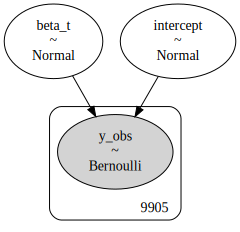

In [18]:
pm.model_to_graphviz(logistic_model)

In [20]:
with logistic_model:
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_t]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 6 seconds.


In [21]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.882,0.023,-0.924,-0.840,0.001,0.0,2065.0,1542.0,1.01
beta_t,-0.008,0.001,-0.010,-0.006,0.000,0.0,2005.0,1290.0,1.00


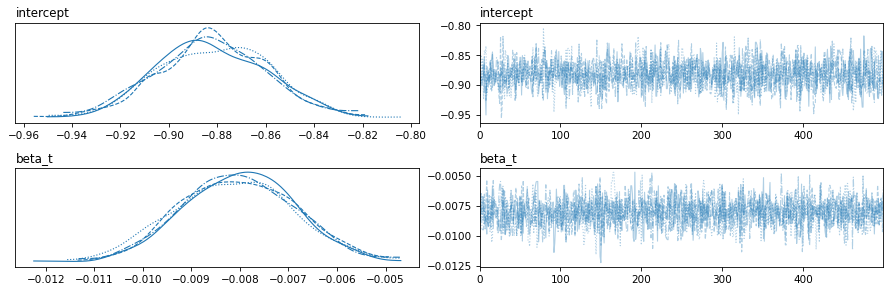

In [22]:
pm.plot_trace(idata)
plt.tight_layout()

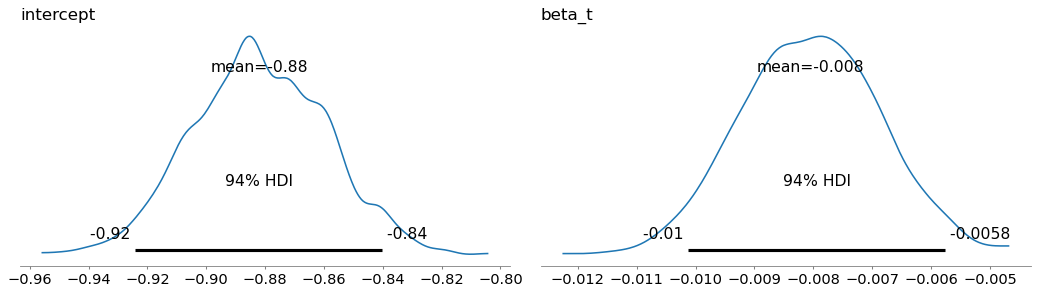

In [23]:
pm.plot_posterior(idata)
plt.tight_layout()

## Contour plots


In [24]:
def get_sample(idata, var_name):
    """Extract a posterior sample from idata
    
    idata: InferenceData object
    var_name: string
    
    returns: NumPy array
    """
    return idata.posterior[var_name].values.flatten()

In [25]:
from scipy.special import expit

intercepts = get_sample(idata, 'intercept')
ps = expit(intercepts)

np.mean(ps), np.percentile(ps, [3, 97])

(0.292813330286978, array([0.28421121, 0.30162003]))

In [26]:
betas = get_sample(idata, 'beta_t')
ps = expit(intercepts + betas * 10)

np.mean(ps), np.percentile(ps, [3, 97])

(0.2764381187049189, array([0.26657467, 0.28668049]))

In [27]:
from scipy.stats import gaussian_kde

def joint_contour(x, y):
    data = np.vstack([x, y])
    kde = gaussian_kde(data)

    xs = np.linspace(x.min(), x.max(), 101)
    ys = np.linspace(y.min(), y.max(), 101)
    X, Y = np.meshgrid(xs, ys, indexing='ij')

    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_values = kde(positions).reshape(X.shape)

    plt.contour(X, Y, kde_values, cmap='Blues')

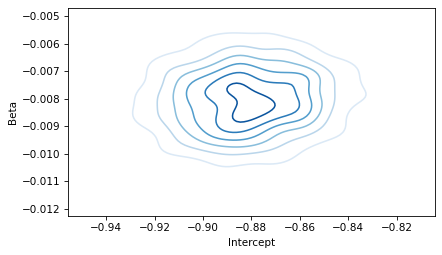

In [28]:
joint_contour(intercepts, betas)
decorate(xlabel='Intercept', ylabel='Beta')

## Predictions

<Axes: xlabel='year'>

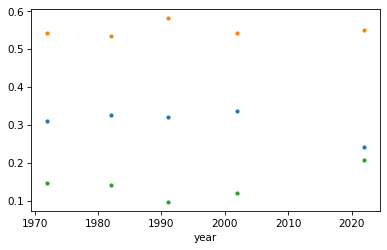

In [33]:
series1 = gss_clean.groupby('year')['y1'].mean()
series2 = gss_clean.groupby('year')['y2'].mean()
series3 = gss_clean.groupby('year')['y3'].mean()

series1.plot(style='.')
series2.plot(style='.')
series3.plot(style='.')

<Axes: xlabel='year'>

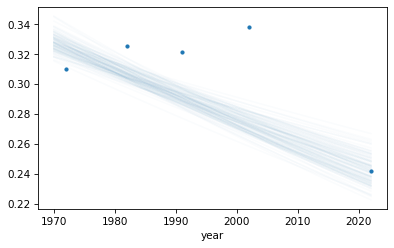

In [34]:
ts = np.linspace(-20, 32)
for inter, beta in zip(intercepts[:100], betas[:100]):
    ys = inter + beta * ts
    ps = expit(ys)
    plt.plot(ts + 1990, ps, color='C0', alpha=0.02)
    
series1.plot(style='.')

## Ordered Logistic Regression

Using OrderedLogistic likelihood

In [35]:
# shift so it's encoded 0, 1, 2
data = gss_clean['happy'].values - 1
pd.Series(data).value_counts().sort_index()

0.0    2913
1.0    5450
2.0    1542
Name: count, dtype: int64

In [36]:
with pm.Model() as ordered_logistic_model:
    
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    beta_t = pm.Normal('beta_t', mu=0, sigma=2)
    
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal('cutpoints', mu=np.array([-1, 1]), sigma=2, shape=2,
                          transform=pm.distributions.transforms.ordered)
    
    # Linear combination of coefficients and independent variables
    eta = intercept + beta_t * t
    
    # Likelihood: ordered logistic regression
    y_obs = pm.OrderedLogistic('y_obs', eta=eta, cutpoints=cutpoints, 
                               compute_p=False, observed=data)

In [37]:
with ordered_logistic_model:
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_t, cutpoints]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 489 seconds.


In [38]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.215,1.178,-2.217,2.298,0.04,0.030,871.0,883.0,1.0
beta_t,0.009,0.001,0.008,0.011,0.00,0.000,1217.0,1000.0,1.0
cutpoints[0],-1.099,1.178,-3.118,1.396,0.04,0.029,871.0,888.0,1.0
cutpoints[1],1.484,1.178,-0.553,3.964,0.04,0.029,871.0,859.0,1.0


## Ordered Logistic Regression

Computing the probabilities explicitly and using Categorical

In [39]:
with pm.Model() as ordered_logistic_model:
    
    # Priors for the coefficients
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    beta_t = pm.Normal('beta_t', mu=0, sigma=2)
    
    # Priors for the cutpoints (thresholds) between categories
    cutpoints = pm.Normal('cutpoints', mu=np.array([-1, 1]), sigma=2, shape=2,
                          transform=pm.distributions.transforms.ordered)
    
    # Linear combination of coefficients and independent variables
    t = pm.Data('t', t)
    eta = intercept + beta_t * t
    
    # Calculate cumulative probabilities for the three categories
    # P(y <= 1), P(y <= 2), and implicitly P(y <= 3) = 1
    p1 = pm.math.sigmoid(cutpoints[0] - eta)
    p2 = pm.math.sigmoid(cutpoints[1] - eta)
    
    # Probabilities for each category (P(y = 1), P(y = 2), P(y = 3))
    p_y1 = p1
    p_y2 = p2 - p1
    p_y3 = 1 - p2
    
    # Combine probabilities into a matrix (each row sums to 1)
    p = pm.math.stack([p_y1, p_y2, p_y3], axis=1)
    
    # Likelihood: categorical distribution for the observed data
    y_obs = pm.Categorical('y_obs', p=p, observed=data)
        
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_t, cutpoints]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 379 seconds.


In [40]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.311,1.136,-2.311,1.898,0.038,0.029,898.0,927.0,1.0
beta_t,0.009,0.001,0.007,0.011,0.000,0.000,1220.0,998.0,1.0
cutpoints[0],-1.196,1.136,-3.183,1.027,0.038,0.028,897.0,914.0,1.0
cutpoints[1],1.390,1.138,-0.640,3.580,0.038,0.027,896.0,971.0,1.0


In [41]:
from scipy.special import expit

intercepts = get_sample(idata, 'intercept')
ps = expit(intercepts)

np.mean(ps), np.percentile(ps, [3, 97])

(0.4394066497724619, array([0.0785229 , 0.86021339]))

In [42]:
betas = get_sample(idata, 'beta_t')
ps = expit(intercepts + betas * 10)

np.mean(ps), np.percentile(ps, [3, 97])

(0.4577288159001164, array([0.08591699, 0.86948096]))

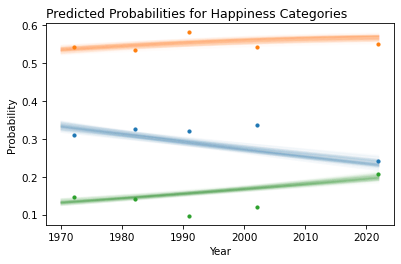

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

# Extract posterior samples
intercepts = idata.posterior['intercept'].values.flatten() 
betas = idata.posterior['beta_t'].values.flatten() 

# Extract the cutpoints
# Combine the chains and draws into a single sample dimension
cutpoints = idata.posterior['cutpoints']
combined_sample = cutpoints.stack(sample=("chain", "draw"))
cutpoint0 = combined_sample.sel(cutpoints_dim_0=0).values
cutpoint1 = combined_sample.sel(cutpoints_dim_0=1).values

# Generate predictions
ts = np.linspace(-20, 32)
for inter, beta, cp0, cp1 in zip(intercepts[:100], betas[:100], cutpoint0[:100], cutpoint1[:100]):
    eta = inter + beta * ts
    
    # Calculate cumulative probabilities
    p1 = expit(cp0 - eta)      # P(y <= 1)
    p2 = expit(cp1 - eta)      # P(y <= 2)
    
    # Calculate category probabilities
    prob_y1 = p1               # P(y = 1)
    prob_y2 = p2 - p1          # P(y = 2)
    prob_y3 = 1 - p2           # P(y = 3)
    
    # Plot each probability over the range of t values
    plt.plot(ts + 1990, prob_y1, color='C0', alpha=0.02)
    plt.plot(ts + 1990, prob_y2, color='C1', alpha=0.02)
    plt.plot(ts + 1990, prob_y3, color='C2', alpha=0.02)
    
# Overlay the original data points (adjust as needed)
series1.plot(style='.')
series2.plot(style='.')
series3.plot(style='.')

plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Predicted Probabilities for Happiness Categories')
plt.show()


In [44]:
# Define new independent variable for prediction
new_t_values = np.linspace(-20, 32)

with ordered_logistic_model:
    # Update the model's data context
    pm.set_data({"t": new_t_values})

    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(idata.posterior, 
                                                          var_names=["y_obs"])

Sampling: [y_obs]


Output()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (50,) and arg 1 with shape (9905,).
Apply node that caused the error: categorical_rv{"(p)->()"}(RNG(<Generator(PCG64) at 0x7F40CF7519A0>), [9905], Join.0)
Toposort index: 9
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(float64, shape=(None, 3))]
Inputs shapes: ['No shapes', (1,), (50, 3)]
Inputs strides: ['No strides', (8,), (24, 8)]
Inputs values: [Generator(PCG64) at 0x7F40CF7519A0, array([9905]), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
# Extract predictions
y_pred = posterior_predictive['y_obs']

# Calculate the mean prediction for each new_t_value
mean_pred = y_pred.mean(axis=0)

# Plot the predictions
plt.plot(new_t_values + 1990, mean_pred, color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Predicted Happiness Level')
plt.title('Predicted Happiness Levels Across Years')
plt.show()